<a href="https://colab.research.google.com/github/sanujsriv/_topic_models/blob/WTM/Copy_of_WTM_Final_agnews_88_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WTM Run-Script (NMSU Server)

In [ ]:
# import os
# from time import time
# import argparse

# parser = argparse.ArgumentParser(description='PRODLDA')
# parser.add_argument('--data_name', type=str, default='bbc', help='bbc,searchsnippet, wos')
# parser.add_argument('--dtype', type=str, default='short', help='full,short,small')
# parser.add_argument('--num_topic', type=str, default='10', help='number of topic')
# parser.add_argument('--num_runs', type=str, default='1', help='num of runs')
# args = parser.parse_args()

# # data_name = 'bbc' # bbc,searchsnippet, wos
# # dtype = 'short' # full,short,small

# data_name = args.data_name
# dtype = args.dtype
# num_topic =args.num_topic
# num_runs = [args.num_runs]

# # data_name = 'bbc'
# # dtype = 'short'
# # num_topic = '10'
# # num_runs = ['1']

# model_name = 'Embedding_Vis_Model'
# home_dir='/home/grad16/sakumar/CIKM_Experiments_2021/'+model_name
# os.chdir(home_dir)

# #num_runs=5

# ## script
# for r in num_runs:
#   os.chdir(home_dir)
#   save_dir = home_dir+"/SavedOutput/"+data_name+"/"+dtype+"/topics_"+str(num_topic)+"/runs_"+str(r)
#   os.makedirs(save_dir,exist_ok=True)
#   os.system("nohup python3 main.py \
#    --dataset "+data_name+" --dtype "+dtype+" --num_topics "+num_topic+" --run "+str(r)+" -e 1000 \
#     > "+save_dir+"/"+"output_"+data_name+"_"+str(num_topic)+".txt")

In [ ]:
model = Model(2000, 100, 100, 2, 10, 0.0, 1.0, 256, 0, 300, distance="gaussian")

NameError: ignored

In [ ]:
# %time
# d_data= 'searchsnippet' # wos,bbc,searchsnippet
# min_df = 0 # we already applied min_df =3 in preprocessing
# dtype='short' # full, short
# dtype2 = 'small' # small , normal

import time,sys

num_of_KNN_ks=5
num_of_runs = 3
model_name = 'Embedding_Vis_Model'

if local:
  home_dir = '/home/grad16/sakumar/CIKM_Experiments_2021/'+model_name+'/content'
elif not local:
  home_dir = '/content'

os.chdir(home_dir)


# all_data = ['bbc','searchsnippet','wos']
# dtypes = ['full','short']
# dtype2 = 'normal'

num_topics = [10]
all_data = ['searchsnippet']
dtypes = ['short']
dtype2 = 'normal'

for d_data in all_data:
  print(d_data+'\n\n')
  for dtype in dtypes:
    print(dtype+'\n\n')
    if d_data=='searchsnippet' and dtype=='full':
      continue

    all_results_ = {
    # '__id__':[],
    # 'sample_id':[],
    'all_indices':[],
    'KNN_Scores':[],
    'vocabs':[], ## save once
    'runtimes':[],
    # 'num_topics':[],
                    }

    save_results_dir = "/content/SavedResults/"+dtype+"/"+dtype2
    model_signature=d_data+'_'+dtype+'_'+dtype2+'_model_'+model_name
    os.makedirs(home_dir+save_results_dir, exist_ok=True)

    loaded_data = load_data(d_data,dtype,dtype2)
    data_preprocessed , data_preprocessed_labels , embeddings, name = loaded_data

    tensor_train_w,train_label,id_vocab = get_data_label_vocab_normal(data_preprocessed,data_preprocessed_labels)
    embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,embeddings)

    os.chdir(home_dir+save_results_dir)
    KNN_scores_list = []
    for num_topic in num_topics:
      with open(str(num_topic)+"_topics_KNN_"+model_signature+".txt", "w") as f:
        runtimes_list_mean = []
        # id_list=[]
        all_indices_list=[]
        KNN_sample_list = []
        runtime_list=[]
        for k in range(num_of_runs):
          # id=1
          num_input = tensor_train_w[0].shape[0]
          start = time.time()
          model,all_indices = train(tensor_train_w,train_label,num_input,num_topic,embedding_tensor_sorted_alp)
          runtime= time.time()-start
          runtime_list.append(runtime)

          f.write("\n | Run - "+str(k+1)+"| data - "+d_data+dtype+dtype2+"| runtime:  "+str(runtime)+"s"+"\n")
          x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,tensor_train_w,train_label,id_vocab)
          topword_topics = get_topwords(beta, id_vocab)
          f.write("---"*10+"\n")
          for topwords in topword_topics:
            f.write(topwords+"\n")
          f.write("---"*10+"\n")
          f.write('KNN: '+str(cal_knn(x_list,labels_list))+', KNN mean score: '+str(np.mean(cal_knn(x_list,labels_list))))
          f.write("\n")
          f.flush()
          os.fsync(f.fileno())
          KNN_sample_list = np.append(KNN_sample_list,[cal_knn(x_list,labels_list)])
        KNN_scores_list = KNN_sample_list.reshape(num_of_runs,num_of_KNN_ks)
        all_results_['KNN_Scores'].append(KNN_scores_list)
        all_results_['runtimes'].append(runtime_list)
        torch.save(model.state_dict(), model_signature+'topics_'+str(num_topic)+'_run_'+str(k+1)+'.pt')

        ail=[t.numpy() for t in all_indices]
        all_indices_list.append(ail)
      all_results_['all_indices'].append(all_indices_list)

    save_obj(all_results_,'all_results_'+model_signature)
  # f.close()

#**0. Just Run these..**

In [ ]:
import os
if 'grad16' in os.getcwd(): local=True
else: local = False
if local == True: os.chdir('/home/grad16/sakumar/')
down_count=0

In [ ]:
## Full data
if local == True:
  model_name = 'Embedding_Vis_Model'
  cur_dir='/home/grad16/sakumar/CIKM_Experiments_2021/'+model_name
  # cur_dir = '/home/grad16/sakumar/colab/preprocessing'
  data_dir = '/'

  os.chdir(cur_dir+data_dir)
  # os.mkdir(model)
  # os.chdir(model_name)
  # os.mkdir(d_data) ## uncomment this if data is new
  # os.chdir(d_data)

In [ ]:
!nvidia-smi

Thu Sep  2 17:50:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pwd

'/content'

In [ ]:
# @title Imports
# from sympy.stats import RaisedCosine, density
if local==False:
  !pip3 install pickle5
import pickle5
import torch
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# %matplotlib inline
import pandas as pd
from torch import Tensor
from torch import nn
import re
from time import time
import numpy as np
import collections
import gc
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
import math
# cos_sim = nn.CosineSimilarity(dim=-1,eps=1e-08)
# from nltk.corpus import stopwords

     |████████████████████████████████| 132 kB 4.0 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219306 sha256=58119a8da59b89e5787ac04d5b558ddb95b4a47d77ed93d38f4996b95b7b1d13
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [ ]:
#@title torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
import math

In [ ]:
#@title function : load / save pickle_obj
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_obj_pkl5(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle5.load(f)

# **Download Data & Helper Functions(Documents)**

In [ ]:
#@title OLDER_Download Data Function

# def download_data(data,dtype):
#   data = data.lower()
#   dtype = dtype.lower()

#   if data=='wos':
#     if dtype == 'full':
#       # os.system('wget -N https://www.dropbox.com/s/krx3am9pfsiidzx/wos_full.zip')
#       # os.system('unzip wos_full.zip')
#       os.system('wget -N https://www.dropbox.com/s/768lhd76l49nsa4/wos_full.zip')
#       os.system('unzip wos_full.zip')

#     if dtype == 'short':
#       os.system('wget -N https://www.dropbox.com/s/aauu04pahwptexz/wos_short.zip')
#       os.system('unzip wos_short.zip')

#   elif data=='bbc':
#     if dtype == 'full':
#       os.system('wget -N https://www.dropbox.com/s/5n7khg6ht1lglb6/bbc_full.zip')
#       os.system('unzip bbc_full.zip')

#     if dtype == 'short':
#       os.system('wget -N https://www.dropbox.com/s/p5pb0w27cp41qeb/bbc_short.zip')
#       os.system('unzip bbc_short.zip')

#   elif data=='searchsnippet':
#     if dtype == 'short':
#        os.system('wget -N https://www.dropbox.com/s/yp0b4wl6w51af47/searchsnippet_short.zip')
#        os.system('unzip searchsnippet_short.zip')

#   else: print('either "data" or "dtype" is entered incorrectly ')


In [ ]:
# @title Old Download Data Function

# def download_data(data,dtype):
#   data = data.lower()
#   dtype = dtype.lower()

#   if data=='wos':
#     if dtype == 'full':
#       os.system('wget -N https://www.dropbox.com/s/w7ryozpj6qq1snx/wos_full4000.zip')
#       os.system('unzip wos_full4000.zip')

#     if dtype == 'short':
#       os.system('wget -N https://www.dropbox.com/s/eqkvxl6z0jwp44u/wos_short4000.zip')
#       os.system('unzip wos_short4000.zip')

#   elif data=='bbc':
#     if dtype == 'full':
#       # os.system('wget -N https://www.dropbox.com/s/a628h7e7lnlasc7/bbc_full2000.zip')
#       # os.system('unzip bbc_full2000.zip')
#       os.system('wget -N https://www.dropbox.com/s/0gbgvvqk4xoqfk6/bbc_full2000_20.zip')
#       os.system('unzip bbc_full2000_20.zip')

#     if dtype == 'short':
#       os.system('wget -N https://www.dropbox.com/s/4ly63afqc7ugz69/bbc_short2000.zip')
#       os.system('unzip bbc_short2000.zip')
#       # os.system('wget -N https://www.dropbox.com/s/l1aargdbd8e3bjm/bbc_short2000_20_4.zip')
#       # os.system('unzip bbc_short2000_20_4.zip')

#   elif data=='searchsnippet':
#     if dtype == 'short':
#        os.system('wget -N https://www.dropbox.com/s/8emmtg3qdqq7vpg/searchsnippet_short3000.zip')
#        os.system('unzip searchsnippet_short3000.zip')

#   else: print('either "data" or "dtype" is entered incorrectly ')


In [ ]:
#@title OLD Data Loading functions..
# def load_data(data,dtype,dtype2):
#   data = data.lower()
#   dtype = dtype.lower()
#   dtype2 = dtype2.lower()
#   d,l,e,fn = load_d_data(data,dtype,dtype2)
#   return d,l,e,fn
# sample_size = 50
# def load_data(data,dtype,dtype2='small'):
#   if (dtype == 'full' or dtype == 'short') and dtype2 == 'normal':
#     data_preprocessed = load_obj('data_preprocessed')
#     data_preprocessed_labels = load_obj("data_preprocessed_labels")
#     embeddings = load_obj('embeddings')
#   elif (dtype == 'full' or dtype == 'short') and dtype2 == 'small':
#     data_preprocessed = load_obj('docs_sampled_small_'+str(sample_size)+data+dtype)
#     data_preprocessed_labels = load_obj("labels_sampled_small_"+str(sample_size)+data+dtype)
#     embeddings = load_obj('embeddings')

#   os.system("rm -r *.pkl")
#   return data_preprocessed,data_preprocessed_labels,embeddings,d_data


In [ ]:
#@title Download Data Function

def download_data(data):
  data = data.lower()
  if data=='wos':
    os.system('wget -N https://www.dropbox.com/s/f3qw75jmsdlyk8j/wos_4000_20.zip')
    os.system('unzip wos_4000_20.zip')

  elif data=='bbc':
     os.system('wget -N https://www.dropbox.com/s/4mmiaed6rg5lpb1/bbc_2000_20.zip')
     os.system('unzip bbc_2000_20.zip')

  elif data=='searchsnippet':
      os.system('wget -N https://www.dropbox.com/s/prk65wqfgvajhd2/searchsnippet_3000_.zip')
      os.system('unzip searchsnippet_3000_.zip')

  # elif data=='searchsnippet':
  #      os.system('wget -N https://www.dropbox.com/s/tq31csl55b3oc09/searchsnippet_3000_20.zip')
  #      os.system('unzip searchsnippet_3000_20.zip')

  else: print('"data" is entered incorrectly ')

In [ ]:
#@title Data Loading Functions

sample_size = 20
small_data_no_of_ids = 1

def load_data(data,dtype,dtype2):
  data = data.lower()
  dtype = dtype.lower()
  dtype2 = dtype2.lower()
  d,l,e,fn = load_d_data(data,dtype,dtype2)
  return d,l,e,fn

def load_data(data,dtype,dtype2):
  if local==True:
    dir ='/content/data_'+data+'/'+dtype
    os.chdir(cur_dir+dir)
  if local==False:
    dir ='/content/content/data_'+data+'/'+dtype
    os.chdir(dir)


  if dtype2=='normal':
      data_preprocessed=load_obj_pkl5("data_preprocessed_"+data+"_"+dtype)
      data_preprocessed_labels=load_obj_pkl5("data_preprocessed_labels_"+data+"_"+dtype)
      embeddings=load_obj_pkl5("embeddings_"+data+"_"+dtype)
      generated_embeddings=load_obj_pkl5("generated_embeddings_"+data+"_"+dtype)

      if local==True:
        os.chdir('/home/grad16/sakumar/CIKM_Experiments_2021/PLSV-VAE')
      if local==False:
        os.chdir('/content/')
      return data_preprocessed,data_preprocessed_labels,embeddings,generated_embeddings,data

  elif dtype2=='small':
    data_preprocessed=[]
    data_preprocessed_labels=[]
    if (dtype == 'full' or dtype == 'short') and dtype2 == 'small':
      for i in range(small_data_no_of_ids):
        id = str(i+1)
        data_preprocessed.append(load_obj(id+'_docs_sampled_'+dtype2+'_'+str(sample_size)+d_data+dtype))
        data_preprocessed_labels.append(load_obj(id+'_labels_sampled_'+dtype2+'_'+str(sample_size)+d_data+dtype))
        embeddings = load_obj('embeddings'+'_'+data+'_'+dtype)
    if local==True:
      os.chdir('/home/grad16/sakumar/CIKM_Experiments_2021/'+model_name)
    if local==False:
      os.chdir('/content/')
    # os.system("rm -r *")
    return data_preprocessed,data_preprocessed_labels,embeddings,d_data


# **1. Preparing Data**

## Download & Load

In [ ]:
if not os.path.exists("VLDB_WTM_Datasets.zip"):
    !wget -N -c https://www.dropbox.com/s/yt01lglmwyfwpot/VLDB_WTM_Datasets.zip
    !unzip -o VLDB_WTM_Datasets.zip

--2021-09-02 17:51:12--  https://www.dropbox.com/s/yt01lglmwyfwpot/VLDB_WTM_Datasets.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yt01lglmwyfwpot/VLDB_WTM_Datasets.zip [following]
--2021-09-02 17:51:13--  https://www.dropbox.com/s/raw/yt01lglmwyfwpot/VLDB_WTM_Datasets.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8f51c00d7250cfd354b7232106.dl.dropboxusercontent.com/cd/0/inline/BVYI0JMsOZ0mG7xF9kga9t4c1kpBwozIakE3lAU4Kadlfd1VzWXppBSqyKbOgMaKJh4lrtyyN3POVRR9uIPtCJkFJtIuFZE4GdGuHzFysZY9ApKL_3QYF_9KinSpZiA7k3wloK72XKEM6s3S0BvT4mru/file# [following]
--2021-09-02 17:51:13--  https://uc8f51c00d7250cfd354b7232106.dl.dropboxusercontent.com/cd/0/inline/BVYI0JMsOZ0mG7xF9kga9t4c1kpBwozIakE3lAU4Kadlfd1VzWXppBSqyKbO

In [ ]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')
def doc_remove_extra_stopwords(doc):
  extra_stopwords = ['la','wa','will','fa','ha','pa','co','v','said']
  doc = word_tokenize(doc)
  doc = filter(lambda x:x not in extra_stopwords, doc)
  doc = ' '.join(e for e in doc)
  return doc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# cd /home/grad16/sakumar/CIKM_Experiments_2021/PLSV-VAE
!pwd

/content


In [ ]:
# !wget https://www.dropbox.com/s/w1aum2lfvx4swaq/stackoverflow_4000_20.zip
# !unzip stackoverflow_4000_20.zip
# !wget https://www.dropbox.com/s/er4nnqu38jou2mn/stackoverflow_4000_20.zip
# !unzip stackoverflow_4000_20.zip
# !wget https://www.dropbox.com/s/p7b2msz5fzqvc1q/agnews120k_4000_.zip
# !unzip agnews120k_4000_.zip
# !wget https://www.dropbox.com/s/0qqv3srqru9xii0/newscategory_4000_20.zip
# !unzip newscategory_4000_20.zip
# !wget https://www.dropbox.com/s/ggg0ustpn13m7z5/yahooanswers_4000_.zip
# !unzip yahooanswers_4000_.zip
# !unzip twentynews_4000_.zip
# !wget https://www.dropbox.com/s/fwm311cjbdg1cdd/agnews120k_8000_.zip
# !unzip agnews120k_8000_.zip
# !wget https://www.dropbox.com/s/hlxlhyzivg3kfbj/yahooanswers_sampled_5000.zip
# !unzip yahooanswers_sampled_5000.zip

In [ ]:
# %cd /content
# !rm -r *

In [ ]:
#### Data Downloading ####
d_data= 'bbc' # wos,bbc,searchsnippet,stackoverflow,agnews120k,yahooanswers,twentynews
# min_df = 0 # we already applied min_df =3 in preprocessing
dtype='short' # full, short
dtype2 = 'normal' # small , normal

# download_data(d_data) ###

# ##### Data loading #####

loaded_data = load_data(d_data,dtype,dtype2)
# loaded_data = load_short_small_data_(d_data,dtype)
# loaded_data = load_small_data(d_data)
##########################

data_preprocessed , data_preprocessed_labels , embeddings,generated_embeddings, name = loaded_data
# for d in range(len(data_preprocessed)):
  # data_preprocessed[d] = doc_remove_extra_stopwords(data_preprocessed[d])
print(name,len(data_preprocessed_labels),len(data_preprocessed),len(embeddings),dtype,dtype2)

bbc 2220 2220 2000 short normal


In [ ]:
if name == 'bbc': max_features = 4000
elif name == 'searchsnippet': max_features = 3000
elif name == 'agnews120k': max_features = 8000
elif name == 'yahooanswers': max_features = 4000
else: max_features = 4000

if dtype2 == "small":
  data_preprocessed = data_preprocessed[0]
  data_preprocessed_labels = data_preprocessed_labels[0]

len_docs = [len(d.split(" ")) for d in data_preprocessed]
print(np.min(len_docs),np.mean(len_docs).round(2),np.max(len_docs))

3 12.02 80


In [ ]:
# !rm -r /content/content/data_bbc
# !wget -N https://www.dropbox.com/s/ql5gpb1v6q6j9s6/bbc_2000_20.zip
# !unzip bbc_2000_20.zip
# %cd /content/content/data_bbc/short/
# new_data = load_obj_pkl5('data_preprocessed_bbc_short')
# new_labels = load_obj_pkl5('data_preprocessed_labels_bbc_short')
# old_embeddings = load_obj_pkl5('embeddings_bbc_short')

In [ ]:
# if local:
  # os.chdir(colab_dir+model_name+'/plsv_vae')
def get_data_label_vocab_for_large_data(data,lables,max_features):
  min_df=0
  preprossed_data = data
  train_label = lables
  print(max_features)
  vectorizer = CountVectorizer(min_df=min_df,max_features=max_features)
  count_vec = vectorizer.fit_transform(preprossed_data)
  vocab = vectorizer.vocabulary_
  id_vocab = dict(map(reversed, vocab.items()))
  print(count_vec.shape,len(vocab))
  print(vocab)
  train_label = np.asarray(train_label)

  return count_vec,train_label,id_vocab


def get_data_label_vocab_normal(data,lables):
  min_df=0
  preprossed_data = data
  train_label = lables
  vectorizer = CountVectorizer(min_df=min_df)
  train_vec = vectorizer.fit_transform(preprossed_data).toarray()
  vocab = vectorizer.vocabulary_
  id_vocab = dict(map(reversed, vocab.items()))
  # nonzeros_indexes = np.where(train_vec.any(1))[0]
  # train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]
  # preprossed_data_non_zeros = [preprossed_data[i] for i in nonzeros_indexes]
  # train_label = [data_preprocessed_labels[i] for i in nonzeros_indexes]
  print(len(train_vec),len(vocab))
  print(vocab)

  tensor_train_w = (torch.from_numpy(np.array(train_vec)).float())
  train_label = np.asarray(train_label)

  return tensor_train_w,train_label,id_vocab

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_coordinate = 2

en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.002
beta1 = 0.99
beta2 = 0.999
drop_rate = 0.0
num_topic = 50

## **Cosine Scores**

In [ ]:
cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
def flatten_list(user_list): return [item for sublist in user_list for item in sublist]
def get_embedding_tensor(word_list,embeddings): return torch.tensor([embeddings[w] for w in word_list])
def get_doc_word_embeddings(id_vocab,embeddings):
  sorted_id_word_vocab = sorted(id_vocab.items(), key=lambda x: x[1]) ### alphabetically sorted
  word_list = [s[1] for s in sorted_id_word_vocab]
  words_tensor = get_embedding_tensor(word_list,embeddings)
  embedding_tensor_sorted_alp = get_embedding_tensor(word_list,embeddings)
  emb_size = embedding_tensor_sorted_alp.shape[1]
  return embedding_tensor_sorted_alp,emb_size

## **Functions (Plot_loss, get_topwords, get_Z, get_Contour, print_Topics)** - *Run Once*

In [ ]:
#@title get_all_tensor_size
def getall_tensor_size():
  for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size(),get_mem_size(obj))
    except:
        pass

In [ ]:
#@title Testing_&_Extra_Fns

# embdding_input_NV300 = embedding_tensor_sorted_alp.unsqueeze(0).expand(tensor_train_w.shape[0],embedding_tensor_sorted_alp.shape[0],embedding_tensor_sorted_alp.shape[1])
# tensor_train_w_input = tensor_train_w
# y = torch.ones(tensor_train_w.size())
# w_input = torch.where(tensor_train_w_input >= 1, y, tensor_train_w_input)
# docWord_embedding_input = w_input.unsqueeze(-1).expand(w_input.shape[0],w_input.shape[1],300) * embdding_input_NV300

# def Log_NormDist_wC(x,mu,sigma=sig0,sigma_ir=sigc,d=emb_size):
#   x_Q = torch.narrow(x,1,0,x.shape[1]-1) # First Q (KxQx300)
#   mu_Q = torch.narrow(mu,1,0,mu.shape[1]-1) # First (KxQx300)
#   x_C_ir = torch.narrow(x,1,x.shape[1]-1,1) # Last C (Kx1x300)
#   mu_C_ir = torch.narrow(mu,1,mu.shape[1]-1,1) # Last C (Kx1x300)

#   First_Q = d/2.0 * torch.log(torch.tensor(sigma/(2.0*pi)))
#   Second_Q = -(sigma/2.0) * (torch.norm(x_Q-mu_Q,dim=-1)**2)

#   First_C_ir = d/2.0 * torch.log(torch.tensor(sigma_ir/(2.0*pi)))
#   Second_C_ir = -(sigma_ir/2.0) * (torch.norm(x_C_ir-mu_C_ir,dim=-1)**2)

#   First = First_Q+First_C_ir
#   Second = torch.cat((Second_Q,Second_C_ir),dim=1)
#   ret = First + Second

#   return ret

def min_max_normalization(ip):
  vmax,_ = torch.max(ip,-1)
  vmin,_ = torch.min(ip,-1)
  vmax = vmax.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  vmin= vmin.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  ip = (ip - vmin) / (vmax-vmin+smoothen)
  return ip

def NewBeta_dist(x,mu,phi_beta,smoothen):
  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu+smoothen) + torch_lgamma(phi_beta * (1-mu)+smoothen ))
  Second_1 = (mu*phi_beta-1) * torch.log(x+smoothen)
  Second_2 = ( (1-mu)*phi_beta-1 )* torch.log(1-x+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def LogL_NewBeta(x,relevant_scores):
  x_norm = torch.norm(x,dim=-1)
  mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)
  # LogL = torch.log(NewBeta_dist(relevant_scores,mu,sig,smoothen)+smoothen)
  LogL = NewBeta_dist(relevant_scores,mu,100.0,smoothen)
  return LogL

# wd_idx = torch.where(tensor_train_w[0]>0.0)
# tensor_train_w[0][wd_idx],wd_idx
# print(data_preprocessed[0])
# print(len(data_preprocessed[0].split(' ')))
# for w in wd_idx[0]:
#   print(id_vocab[w.item()],)
# print(wd_idx[0].shape)

# id_word_input = []
# count = 0
# dum_vocab = []
# for data in data_preprocessed:
#   doc = []
#   for w in data.split(' '):
#     if w in vocab and w not in dum_vocab:
#       dum_vocab.append(w)
#     if(w in vocab): doc.append(dum_vocab.index(w))
#   id_word_input.append(doc)
#   # print(data.split(' '))
#   # id_word_input.append(sorted([vocab[p] for p in data.split(' ') if p in vocab]))
#   #id_word_input.append([vocab[p] for p in data.split(' ') if p in vocab])
#   count = count + 1


############################
        # Testing #
############################
# a = torch.ones(12,10) * 4
# b = torch.ones(2,1)
# torch.norm(b,dim=0)
###
# for i in range(12):
#   a[i] = i
# a.unsqueeze(1).expand(12,5,10)
###
# x = torch.rand(5,4,3)
# a=torch.narrow(x,1,0,x.shape[1]-1) # First
# b=torch.narrow(x,1,x.shape[1]-1,1) # Last
# torch.cat((a,b),dim=1)
##
# a_muz = torch.rand(10,300) * 2.0
# b_wnm = torch.rand(20,300) * 4.0
# a = a_muz.unsqueeze(1).expand(10,20,300)
# b = b_wnm.unsqueeze(0).expand(10,20,300)
# c = torch.norm(a-b,dim=-1)**2

In [ ]:
import plotly.graph_objects as go
def plot_loss(y,name):
  figure = go.Figure()
  figure.add_trace(go.Scatter(x=[i for i in range(1,epochs+1)], y=y,mode='lines',name=name))
  figure.show(renderer='colab')

In [ ]:
def get_topwords(beta, id_vocab):
    topic_indx = 0
    no_of_topwords = 10
    topwords_topic = []
    for i in range(len(beta)):
        topwords_topic.append(str(topic_indx)+": "+ " ".join([id_vocab[j] for j in beta[i].argsort()[:-no_of_topwords - 1:-1]]))
        topic_indx+=1
    return topwords_topic

In [ ]:
def get_Z(X,Y):
  norms = torch.zeros(X.shape)
  Z = torch.zeros(X.shape)

  for i in range(X.shape[0]):
    for j in range(X.shape[0]):
      v = torch.tensor([X[i][j],Y[i][j]])

      norms[i][j] = torch.norm(v)
      Z[i][j]=torch.exp(-0.5 * (torch.pow(norms[i][j],2))/mu_div)

      # norms[i][j] = (v-query_center.T).pow(2).sum(-1)
      # Z[i][j]=torch.exp(-0.5 * norms[i][j]/mu_div)
  return Z

In [ ]:
def get_Contour(ax,x_list,lim):
  xlist = np.linspace(-lim, lim, 200)
  ylist = np.linspace(-lim, lim, 200)
  X, Y = np.meshgrid(xlist, ylist)
  Z = get_Z(X,Y)
  levels = np.arange(0,1,0.1)
  cp = ax.contour(X, Y, Z, levels=levels)
  ax.clabel(cp, inline=1, fontsize=10)

In [ ]:
import seaborn as sb

def plot_fig(zx, labels_list, zphi,lim,contour='No'):
    labels = []
    for i in range(len(labels_list)):
        labels.append('C'+str(labels_list[i]))
    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))
    ax.text(0,0, 'X' ,c='black')
    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
def print_Topics(beta):
  print("---"*10)
  topword_topics = get_topwords(beta, id_vocab)
  topword_topics_list=[]
  for topwords in topword_topics:
      topword_topics_list.append(topwords.split())
      print(topwords)
  print("---"*10)

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
def cal_knn(coordinate, label):
    output = []
    for n_neighbors in [10, 20, 30, 40, 50]:
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1, algorithm='auto')
        neigh.fit(coordinate, label)
        output.append(neigh.score(coordinate, label))
    return output

# **Current Working Model**

## Model

### Skipgram/CBOW  Embeddings

In [ ]:
# os.chdir('/content')
# # stop=5
# with open('data.txt','w') as f:
#   # count = 0
#   for d in data_preprocessed:
#     f.write(d+'\n')
#     # count = count +1
#     # if count==stop:
#     #   break

In [ ]:
# <STORE RESULTS --> EXCEL>
## For confirmation :- {First run bbc 5 times - WTM | all topics}
## For confirmation :- {First run searchsnippet 5 times - WTM,ETM,GPUDMM | all topics}
## For confirmation :- {First run agnews 5 times - WTM,PLSV,ETM,GPUDMM | all topics}

## yahoo?: --> yahoo50k


### Run agnews 5 times - new embeddings - take avg - all topics
### Run ssnip 5 times - new embeddings - take avg - all topics]


### Run  5 times - new embeddings - take avg - all topics

In [ ]:
# class MySentences(object):
#     def __init__(self, filename):
#         self.filename = filename

#     def __iter__(self):
#         for line in open(self.filename):
#             yield line.split()

# import gensim
# # Gensim code to obtain the embeddings
# sentences = MySentences('data.txt') # a memory-friendly iterator

# model = gensim.models.Word2Vec(sentences, min_count=2, sg=1, size=300,
#                                iter=50, negative=10, window=4)

# # model = gensim.models.Word2Vec(sentences, min_count=2, sg=0, size=300,
# #                                iter=50, negative=10, window=4)

# # Write the embeddings to a file
# with open('data_embeddings.txt', 'w') as f:
#     for v in list(model.wv.vocab):
#         vec = list(model.wv.__getitem__(v))
#         f.write(v + ' ')
#         vec_str = ['%.9f' % val for val in vec]
#         vec_str = " ".join(vec_str)
#         f.write(vec_str + '\n')

In [ ]:
# !zip data_embeddings.zip data_embeddings.txt
# model.save("agnews120k_skipgram_word2vec.model")
# !zip agnews120k_skipgram_word2vec.zip agnews120k_skipgram_word2vec.model
# !cp agnews120k_skipgram_word2vec.zip /content/drive/MyDrive/Colab\ Notebooks/WTM

In [ ]:
# sg_embeddings = {}
# for v in list(model.wv.vocab):
#   vec = model.wv.__getitem__(v)
#   sg_embeddings[v] =vec
# # sg_embeddings

In [ ]:
# model.wv.most_similar('reuters')
# for x in ms:
#     print (x[0],x[1])
# cos_sim(torch.tensor(sg_embeddings['coffee']),torch.tensor(sg_embeddings['bad']))

In [ ]:
# def nearest_neighbors(word, embeddings, vocab):
#     # vectors = embeddings.data.cpu().numpy()
#     vectors = embeddings
#     index = vocab.index(word)
#     print('vectors: ', vectors.shape)
#     query = vectors[index]
#     print('query: ', query.shape)
#     ranks = vectors.dot(query).squeeze()
#     denom = query.T.dot(query).squeeze()
#     denom = denom * np.sum(vectors**2, 1)
#     denom = np.sqrt(denom)
#     ranks = ranks / denom
#     mostSimilar = []
#     [mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
#     nearest_neighbors = mostSimilar[:20]
#     nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]
#     return nearest_neighbors
# # nearest_neighbors('reuters',sg_embeddings['reuters'],list(model.wv.vocab))

In [ ]:
# sg_embeddings_alp,emb_size = get_doc_word_embeddings(id_vocab,sg_embeddings)

### Currently Working Model

In [ ]:
# from audtorch.metrics.functional import pearsonr
# a = torch.rand(100,64)
# b = torch.rand(100,64)
# pearsonr(a,b).squeeze(-1)

In [ ]:
# !pip install audtorch
# from audtorch.metrics.functional import pearsonr

torch.cuda.empty_cache()
cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)

bs = 5000

en1_units_x = 100
en2_units_x = 100
# en3_units_x = 100

learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999
drop_rate = 0.2

# num_topic = 50
# emb_size = 300

smoothen = 1e-6
variance_x = 1.0
pi = torch.acos(torch.zeros(1)).item() * 2

def get_unit_len_embeddings(my_tensor):
  return my_tensor/(torch.norm(my_tensor,dim=-1).unsqueeze(1))

def get_centered_embeddings(embedding_tensor):
  embedding_centered_tensor = embedding_tensor - embedding_tensor.mean(0)
  return embedding_centered_tensor

#phi
def gaussian(alpha): return -0.5*alpha
#def inverse_multi_quadric(alpha): return -0.5*torch.log(torch.ones_like(alpha) + alpha)
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words, word_emb_size, distance="gaussian"):

        super(Model, self).__init__()
        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs \
            = num_input, num_coordinate, num_topic, variance_x, bs

        self.embedding_words = embedding_words
        self.emb_size = word_emb_size

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)
        # self.en3_fc     = nn.Linear(en2_units_x, en3_units_x)


        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc = nn.Linear(100, 300)
        self.mu_z = 0

        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)

        # self.mean_fc    = nn.Linear(en3_units_x, num_coordinate)
        # self.logvar_fc  = nn.Linear(en3_units_x, num_coordinate)

        self.mean_bn    = nn.BatchNorm1d(num_coordinate)
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)
        self.mu_z_bn = nn.BatchNorm1d(self.emb_size)

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic
        self.centres = nn.Parameter(torch.Tensor(self.out_features, self.in_features)) # K x 2
        #self.mu_z = nn.Parameter(torch.Tensor(self.out_features,self.emb_size))# K x 300

        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))
        # self.mu_z =nn.Embedding(self.out_features,self.emb_size)# K x 300
        # mu_z_MultiNormal = torch.normal(mean=self.embedding_words.mean(0).unsqueeze(0).expand(self.out_features,self.emb_size),std=0.00001) # Kx300
        # self.mu_z = nn.Parameter(mu_z_MultiNormal)

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        self.init_parameters()

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

        self._max_norm_val = 1.0

    def init_parameters(self):
        nn.init.normal_(self.centres, 0, 0.1)
        #nn.init.normal_(self.mu_z, 0, 0.01)
        nn.init.normal_(self.beta_bias, 0, 0.01)

    def max_norm_(self, w): #https://discuss.pytorch.org/t/how-to-correctly-implement-in-place-max-norm-constraint/96769/4
      with torch.no_grad():
        norm = w.norm(2, dim=0, keepdim=True)#.clamp(min=self._max_norm_val / 2)
        desired = torch.clamp(norm, max=self._max_norm_val)
        w *= (desired / norm)
    def encode(self, input_,normalized_input_):
        N, *_ = input_.size()
        # en1 = F.softplus(self.en1_fc(input_))                           # en1_fc   output
        # en2 = F.softplus(self.en2_fc(en1))                              # encoder2 output

        #self.max_norm_(self.en1_fc.weight)
        #self.max_norm_(self.en2_fc.weight)
        en1 = F.softplus((self.en1_fc(input_)))                           # en1_fc   output
        en2 = F.softplus((self.en2_fc(en1)))                              # encoder2 output
        # en3 = F.relu(self.en3_fc(en2))
        en2 = self.en2_drop(en2)

        #self.max_norm_(self.mean_fc.weight)
        posterior_mean   = self.mean_bn(self.mean_fc(en2))          # posterior mean
        #self.max_norm_(self.logvar_fc.weight)
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))          # posterior log variance

        # posterior_mean   = self.mean_bn(self.mean_fc(en3))          # posterior mean
        # posterior_logvar = self.logvar_bn(self.logvar_fc(en3))          # posterior log variance

        # posterior_mean   = (self.mean_fc(en2))          # posterior mean NO BN
        # posterior_logvar = (self.logvar_fc(en2))          # posterior log variance NO BN

        posterior_var    = posterior_logvar.exp()
        # print(torch.min(posterior_var) , torch.max(posterior_var) )

        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_multi_sample(self, input_, posterior_mean, posterior_var, prior_var):
        z_list = []
        for i in range(1):
          eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1.0) # noise
          z_list.append(posterior_mean + posterior_var.sqrt() * eps)     # reparameterization
        return z_list

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1.0) # noise
        # print(input_.data.new().resize_as_(posterior_mean.data))

        z = posterior_mean + posterior_var.sqrt() * eps     # reparameterization
        return z

    def get_beta(self):
      return F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T + self.beta_bias,dim=-1)
      # return F.softmax(self.decoder_bn(torch.mm(self.mu_z_bn(self.mu_z),self.embedding_words.T).T).T,dim=-1)

    def multi_decode(self, z_list):

      zx_list = []
      reconv_list = []
      N, *_ = z_list[0].size()
      size = (N, self.out_features, self.in_features) # N,K,2
      # zc = self.centres
      zc = self.decoder_phi_bn(self.centres)
      c = zc.view(1, self.num_topic, self.num_coordinate).expand(size)
      beta = self.get_beta()

      for z in z_list:
        ## Theta - P(z|x,phi)

        zx =  self.decoder_x_bn(z) # Nx2
        zx_list.append(zx)
        x = zx.view(N, 1, self.num_coordinate).expand(size) # Nx1x2
        # zx = z
        d = (x-c).pow(2).sum(-1)
        distances = self.basis_func(d)
        zx_phi = torch.exp(distances - torch.logsumexp(distances, dim=-1, keepdim=True)) # N x K


        recon_v = torch.mm(zx_phi,beta)
        reconv_list.append(recon_v)

      zxl_sum = 0
      for zxl in zx_list:
        zxl_sum +=zxl
      zx = zxl_sum/len(zx_list)

      return reconv_list, zx, zx_phi, d,zc

    def decode(self, z):

        ## Theta - P(z|x,phi)
        N, *_ = z.size()
        size = (N, self.out_features, self.in_features) # N,K,2
        zx =  self.decoder_x_bn(z) # Nx2
        # zx = z

        x = zx.view(N, 1, self.num_coordinate).expand(size) # Nx1x2

        # zc = self.centres
        zc = self.decoder_phi_bn(self.centres)
        #zc = self.decoder_x_bn(self.centres)

        c = zc.view(1, self.num_topic, self.num_coordinate).expand(size)
        d = (x-c).pow(2).sum(-1)
        distances = self.basis_func(d)
        zx_phi = torch.exp(distances - torch.logsumexp(distances, dim=-1, keepdim=True)) # N x K

        mu1 = F.softplus((self.mu1_fc(zc)))                           # en1_fc   output
        mu2 = F.softplus(self.en2_drop(self.mu2_fc(mu1)))
        self.mu_z = self.mu_fc(mu2)
        beta = self.get_beta()
        recon_v = torch.mm(zx_phi,beta)

        return recon_v, zx, zx_phi, d,zc

    def forward(self, input_,normalized_input_, compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_,normalized_input_)

        z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)

        # z_list = self.take_multi_sample(input_, posterior_mean, posterior_var, self.variance_x)
        # recon_v, zx, zx_phi,d,zc= self.multi_decode(z_list)

        recon_v, zx, zx_phi,d,zc= self.decode(z)

        if compute_loss:
            return recon_v, zx,self.loss(input_, recon_v, zx_phi, posterior_mean, posterior_logvar, posterior_var, d,zx)
        else: return z, recon_v, zx,zc, zx_phi

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return xKLD

    def loss(self, input_, recon_v, zx_phi, posterior_mean, posterior_logvar, posterior_var, d, zx,avg=True):
        N = posterior_mean.shape[0]
        # NL = 0
        # for recon in recon_v:
        #   NL += - (input_ * (recon+smoothen).log()).sum(-1) # (Word_Count_input_loss)
        # NL = NL/len(recon_v)
        # # NL = - (input_ * recon_v).sum(-1) # (Word_Count_input_loss)

        NL = - (input_ * (recon_v+smoothen).log()).sum(-1)

        NL= NL.mean(0)
        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).mean(0)
        loss = NL#+KLD
        return loss,NL,KLD

## Train & Test

In [ ]:
def train_for_large(count_vec,train_label,num_input,num_topic,
                    embedding_tensor_sorted_alp,all_indices,epochs):

  embedding_tensor_words = embedding_tensor_sorted_alp # norm_emb_alp
  embedding_tensor_words_d = embedding_tensor_words.to(device)
  kld_arr,recon_arr = [],[]

  model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                embedding_tensor_words_d,emb_size, "gaussian")
  model.to(device)

  optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # ,weight_decay=1.2 * 1e-6
  # epochs = 1000
  for epoch in range(epochs):

      loss_u_epoch = 0.0 ## NL loss
      loss_KLD = 0.0  ## KL loss
      loss_epoch = 0.0 ## Loss per batch #

      model.train()
      zx_l = []
      label_l = []
      for batch_ndx in all_indices:
        input_w = torch.from_numpy(count_vec[batch_ndx].toarray()).float().to(device)
        normalized_inputw = input_w/(input_w.sum(1).unsqueeze(1))
        labels = train_label[batch_ndx]
        label_l.extend(labels)
        recon_v, zx,(loss, loss_u, xkl_loss) = model(input_w,normalized_inputw,compute_loss=True)
        zx_l.extend(zx.data.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()             # backpror.step()
        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        current_model = model
      kld_arr.append(loss_KLD)
      recon_arr.append(loss_u_epoch)

      if epoch % 10 == 0:
          #  print('Epoch -> {}'.format(epoch))
          print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
          print('recon_loss==> {} || KLD==> {}'.format(loss_u_epoch, loss_KLD))
          # plot_fig(np.array(zx_l),label_l,model.decoder_phi_bn(model.centres).data.cpu().numpy(),10.0,'No')
  return current_model

def test_for_large(model,all_indices,tensor_train_w,train_label,id_vocab):
  model.eval()
  x_list = []
  labels_list = []
  doc_ids = []
  zx_phi_list=[]
  with torch.no_grad():
      for batch_ndx in all_indices:
          # input_w = tensor_train_w[batch_ndx].to(device)
          input_w = torch.from_numpy(count_vec[batch_ndx].toarray()).float().to(device)
          normalized_inputw = input_w/(input_w.sum(1).unsqueeze(1))
          labels = train_label[batch_ndx]
          labels_list.extend(labels)

          z, recon_v, zx,zphi, zx_phi = model(input_w,normalized_inputw,compute_loss=False)
          zx = zx.data.detach().cpu().numpy()
          # zphi = zphi.data.detach().cpu().numpy()
          zx_phi = zx_phi.view(-1, num_topic).data.detach().cpu().numpy()
          zx_phi_list.extend(zx_phi)
          x_list.extend(zx)
          doc_ids.extend(batch_ndx)

      x_list = np.array(x_list)
      beta = model.get_beta().data.cpu().numpy()
      # zphi = model.decoder_phi_bn(model.centres).data.cpu().numpy()
      # zphi = model.centres.data.cpu().numpy()
  print_Topics(beta)
  knn_score = cal_knn(x_list,labels_list)

  print('KNN:- ',knn_score,np.mean(knn_score))
  return x_list,labels_list,zphi,doc_ids,beta

In [ ]:
def train(tensor_train_w,train_label,num_input,num_topic,
          embedding_tensor_sorted_alp,all_indices,epochs):

  embedding_tensor_words = embedding_tensor_sorted_alp # norm_emb_alp
  embedding_tensor_words_d = embedding_tensor_words.to(device)
  kld_arr,recon_arr = [],[]

  model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                embedding_tensor_words_d,emb_size, "gaussian")
  model.to(device)
  print(learning_rate,beta1,beta2)
  optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # ,weight_decay=1.2 * 1e-6
  # epochs = 1000

  for epoch in range(epochs):

      loss_u_epoch = 0.0 ## NL loss
      loss_KLD = 0.0  ## KL loss
      loss_epoch = 0.0 ## Loss per batch #

      model.train()
      zx_l = []
      label_l = []
      for batch_ndx in all_indices:
      # batch_ndx = all_indices[0]
        input_w = tensor_train_w[batch_ndx].to(device)
        normalized_inputw = input_w/(input_w.sum(1).unsqueeze(1))
        labels = train_label[batch_ndx]
        label_l.extend(labels)
        recon_v, zx,(loss, loss_u, xkl_loss) = model(input_w,normalized_inputw,compute_loss=True)
        zx_l.extend(zx.data.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()             # backpror.step()
        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        current_model = model
      kld_arr.append(loss_KLD)
      recon_arr.append(loss_u_epoch)

      if epoch % 10 == 0:
          #  print('Epoch -> {}'.format(epoch))
          print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
          print('recon_loss==> {} || KLD==> {}'.format(loss_u_epoch, loss_KLD))
          # plot_fig(np.array(zx_l),label_l,model.decoder_phi_bn(model.centres).data.cpu().numpy(),10.0,'No')
  return current_model

In [ ]:
def test(model,all_indices,tensor_train_w,train_label,id_vocab):

  model.eval()
  x_list = []
  labels_list = []
  doc_ids = []
  zx_phi_list=[]
  with torch.no_grad():
      for batch_ndx in all_indices:
          input_w = tensor_train_w[batch_ndx].to(device)
          normalized_inputw = input_w/(input_w.sum(1).unsqueeze(1))
          labels = train_label[batch_ndx]
          labels_list.extend(labels)

          z, recon_v, zx,zphi, zx_phi = model(input_w,normalized_inputw,compute_loss=False)
          zx = zx.data.detach().cpu().numpy()
          zphi = zphi.data.detach().cpu().numpy()
          zx_phi = zx_phi.view(-1, num_topic).data.detach().cpu().numpy()
          zx_phi_list.extend(zx_phi)
          x_list.extend(zx)
          doc_ids.extend(batch_ndx)

      x_list = np.array(x_list)
      beta = model.get_beta().data.cpu().numpy()
      # zphi = model.decoder_phi_bn(model.centres).data.cpu().numpy()
      # zphi = model.centres.data.cpu().numpy()

  print_Topics(beta)
  knn_score = cal_knn(x_list,labels_list)
  print('KNN:- ',knn_score,np.mean(knn_score))
  return x_list,labels_list,zphi,doc_ids,beta

# 1 - Run(searchsnippet)

In [ ]:
# count_vec,train_label,id_vocab = get_data_label_vocab_for_large_data(data_preprocessed,data_preprocessed_labels,max_features)
# count_vec,train_label,id_vocab = get_data_label_vocab_normal(new_data,new_labels)
# embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,old_embeddings)

count_vec,train_label,id_vocab = get_data_label_vocab_normal(data_preprocessed,data_preprocessed_labels)
all_indices = torch.randperm(count_vec.shape[0]).split(bs)
embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,generated_embeddings)

12267 3000
{'manufacture': 1678, 'manufacturer': 1679, 'directory': 791, 'china': 456, 'taiwan': 2685, 'product': 2169, 'exporter': 1008, 'supplier': 2650, 'electronics': 909, 'manufacturing': 1680, 'procurement': 2167, 'homepage': 1318, 'magazine': 1651, 'power': 2122, 'production': 2170, 'data': 702, 'management': 1670, 'paper': 1988, 'true': 2805, 'cost': 639, 'design': 752, 'save': 2390, 'metal': 1749, 'searchable': 2422, 'database': 703, 'service': 2452, 'cad': 361, 'drawing': 849, 'nanotechnology': 1846, 'molecular': 1795, 'software': 2526, 'controlled': 619, 'extra': 1013, 'epa': 947, 'gov': 1217, 'buy': 354, 'organization': 1955, 'content': 610, 'osha': 1965, 'topic': 2760, 'safety': 2380, 'health': 1275, 'issue': 1487, 'phase': 2041, 'portland': 2113, 'pre': 2127, 'cast': 400, 'pool': 2106, 'filter': 1066, 'pump': 2212, 'california': 369, 'article': 153, 'cisco': 477, 'india': 1390, 'news': 1870, 'system': 2679, 'facility': 1016, 'south': 2542, 'domestic': 837, 'indian': 1391,

In [ ]:
# torch.var(embedding_tensor_sorted_alp),torch.mean(embedding_tensor_sorted_alp),torch.min(embedding_tensor_sorted_alp),torch.max(embedding_tensor_sorted_alp)

In [ ]:
## normal - kld
from time import time
fstart = time()
epochs = 1000
num_topic = 50
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

0.001 0.99 0.999
Epoch -> 0 , loss -> 1330.0069885253906
recon_loss==> 1330.0069885253906 || KLD==> 21.514904141426086
Epoch -> 10 , loss -> 1255.3910369873047
recon_loss==> 1255.3910369873047 || KLD==> 21.0755877494812
Epoch -> 20 , loss -> 1226.3849716186523
recon_loss==> 1226.3849716186523 || KLD==> 23.672369480133057
Epoch -> 30 , loss -> 1209.0907669067383
recon_loss==> 1209.0907669067383 || KLD==> 28.473604679107666
Epoch -> 40 , loss -> 1188.2027053833008
recon_loss==> 1188.2027053833008 || KLD==> 34.694220542907715
Epoch -> 50 , loss -> 1173.8140716552734
recon_loss==> 1173.8140716552734 || KLD==> 41.70020008087158
Epoch -> 60 , loss -> 1162.5215148925781
recon_loss==> 1162.5215148925781 || KLD==> 48.900055170059204
Epoch -> 70 , loss -> 1150.5323944091797
recon_loss==> 1150.5323944091797 || KLD==> 56.46742057800293
Epoch -> 80 , loss -> 1137.6485748291016
recon_loss==> 1137.6485748291016 || KLD==> 64.51166439056396
Epoch -> 90 , loss -> 1125.1806716918945
recon_loss==> 1125.18

In [ ]:
x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)
print("Dropout: ",drop_rate)

------------------------------
0: intel memory computer processor chip device amd hardware driver cpu
1: journal biology natural ecology cell hazard science evolution biomedical bioinformatics
2: business job electrical service internet marketing product network bandwidth security
3: political council europe reform muslim union conflict soviet european philosophy
4: school faculty thesis elementary student district master phd university library
5: health drug stress medication medical gov nih pressure disease medicine
6: fashion designer car camera digital graduation filmmaking design model photography
7: skating sport figure swimming athletics goalkeeper university swim school wrestling
8: racing horse sport golf tiger wood news football kick championship
9: gov federal budget legislation trade medicare government economy tax economic
10: science space exploration newton nasa universe news institute wikipedia philosophy
11: cancer hiv disease treatment diagnosis aid prevention symptom

In [ ]:
# plot_fig(x_list, labels_list,zphi,lim =30,contour='no')

# 1 - Run(bbc)

In [ ]:
# count_vec,train_label,id_vocab = get_data_label_vocab_for_large_data(data_preprocessed,data_preprocessed_labels,max_features)
# count_vec,train_label,id_vocab = get_data_label_vocab_normal(new_data,new_labels)
# embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,old_embeddings)

count_vec,train_label,id_vocab = get_data_label_vocab_normal(data_preprocessed,data_preprocessed_labels)
all_indices = torch.randperm(count_vec.shape[0]).split(bs)
embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,generated_embeddings)

2220 2000
{'sale': 1542, 'boost': 204, 'time': 1822, 'profit': 1387, 'quarterly': 1419, 'medium': 1122, 'giant': 749, 'jumped': 963, 'three': 1816, 'month': 1162, 'december': 463, 'year': 1994, 'earlier': 557, 'dollar': 518, 'gain': 730, 'greenspan': 778, 'speech': 1676, 'hit': 833, 'highest': 828, 'level': 1032, 'euro': 600, 'federal': 654, 'reserve': 1486, 'head': 811, 'trade': 1843, 'deficit': 472, 'set': 1598, 'unit': 1885, 'buyer': 250, 'face': 626, 'loan': 1054, 'claim': 331, 'owner': 1251, 'russian': 1538, 'oil': 1224, 'production': 1385, 'pay': 1274, 'high': 826, 'fuel': 722, 'price': 1368, 'british': 227, 'airway': 48, 'blamed': 181, 'drop': 546, 'takeover': 1780, 'talk': 1783, 'lift': 1041, 'share': 1604, 'drink': 542, 'food': 694, 'firm': 685, 'risen': 1511, 'speculation': 1675, 'target': 1785, 'france': 710, 'japan': 935, 'recession': 1449, 'economy': 567, 'technical': 1792, 'september': 1591, 'figure': 671, 'job': 943, 'growth': 785, 'slow': 1638, 'created': 418, 'fewer': 

In [ ]:
# torch.var(embedding_tensor_sorted_alp),torch.mean(embedding_tensor_sorted_alp),torch.min(embedding_tensor_sorted_alp),torch.max(embedding_tensor_sorted_alp)

In [ ]:
## normal - kld
from time import time
fstart = time()
epochs = 1000
num_topic = 50
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

0.001 0.99 0.999
Epoch -> 0 , loss -> 845.451286315918
recon_loss==> 845.451286315918 || KLD==> 14.928297400474548
Epoch -> 10 , loss -> 793.1700134277344
recon_loss==> 793.1700134277344 || KLD==> 15.011520147323608
Epoch -> 20 , loss -> 772.5744934082031
recon_loss==> 772.5744934082031 || KLD==> 14.677902102470398
Epoch -> 30 , loss -> 757.2656555175781
recon_loss==> 757.2656555175781 || KLD==> 16.136155009269714
Epoch -> 40 , loss -> 747.6245498657227
recon_loss==> 747.6245498657227 || KLD==> 18.247767567634583
Epoch -> 50 , loss -> 737.2948913574219
recon_loss==> 737.2948913574219 || KLD==> 20.891057014465332
Epoch -> 60 , loss -> 729.0290451049805
recon_loss==> 729.0290451049805 || KLD==> 23.774784088134766
Epoch -> 70 , loss -> 723.3374786376953
recon_loss==> 723.3374786376953 || KLD==> 26.733304738998413
Epoch -> 80 , loss -> 718.1325454711914
recon_loss==> 718.1325454711914 || KLD==> 29.613688230514526
Epoch -> 90 , loss -> 714.1413116455078
recon_loss==> 714.1413116455078 || KL

In [ ]:
x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)
print("Dropout: ",drop_rate)

------------------------------
0: box office chart film single top elvis band number pop
1: game video dvd market set definition news year family firm
2: nation ireland england france wale saturday italy scotland coach side
3: musical rock premiere singer bowl super music sir film concert
4: mobile gadget phone apple mac technology mini consumer player tech
5: law ban government guantanamo terror david suspect hunting hunt bay
6: brother star big celebrity series television actor comedy bbc johnny
7: takeover firm share buy loss group job giant talk profit
8: film singer star bbc jackson rapper died campbell feud company
9: oscar actor film award best aviator star win prize nominee
10: manchester united manager ferguson arsenal bos city coach wenger football
11: blair brown tony election gordon budget kennedy tory trust general
12: digital computer apple people online help music user firm net
13: peer apple network music woman film legal spanish radio pirate
14: liverpool benitez chels

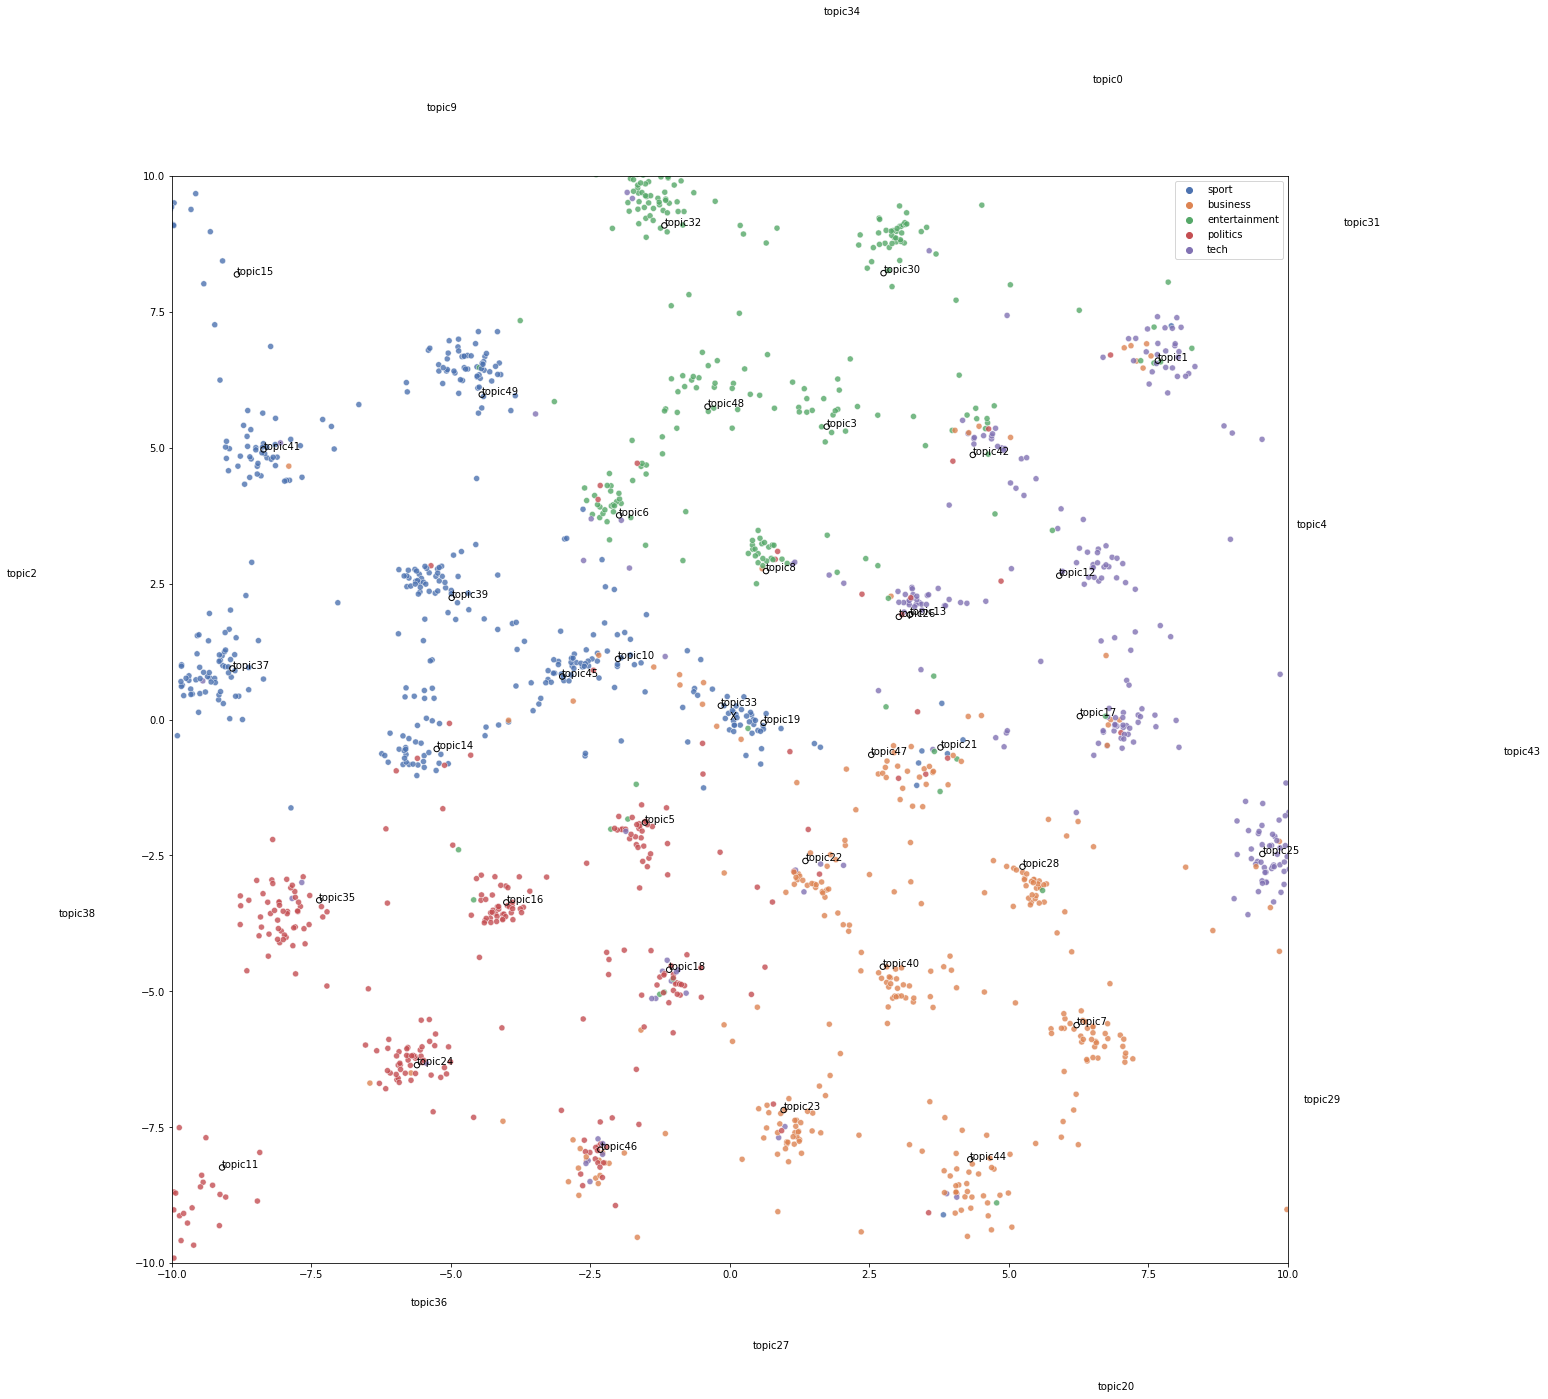

In [ ]:
plot_fig(x_list, labels_list,zphi,lim =10,contour='no')

# 1 - Run(yahoo)

In [ ]:
# count_vec,train_label,id_vocab = get_data_label_vocab_for_large_data(data_preprocessed,data_preprocessed_labels,max_features)
# count_vec,train_label,id_vocab = get_data_label_vocab_normal(new_data,new_labels)
# embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,old_embeddings)

count_vec,train_label,id_vocab = get_data_label_vocab_normal(data_preprocessed,data_preprocessed_labels)
all_indices = torch.randperm(count_vec.shape[0]).split(bs)
embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,generated_embeddings)

50000 4000
{'energy': 1192, 'united': 3755, 'state': 3400, 'business': 484, 'invest': 1861, 'result': 2997, 'term': 3588, 'profit': 2770, 'level': 2062, 'stage': 3389, 'product': 2764, 'requirement': 2977, 'school': 3113, 'answer': 148, 'search': 3133, 'engine': 1195, 'find': 1379, 'specific': 3354, 'form': 1435, 'travel': 3698, 'trade': 3682, 'left': 2049, 'abusive': 19, 'boyfriend': 421, 'kid': 1971, 'car': 529, 'broke': 452, 'guess': 1592, 'rain': 2850, 'opening': 2470, 'resort': 2985, 'havent': 1636, 'housing': 1733, 'suggestion': 3480, 'running': 3068, 'idea': 1760, 'contact': 767, 'plan': 2642, 'company': 713, 'operation': 2473, 'job': 1930, 'soft': 3311, 'experience': 1273, 'java': 1912, 'extra': 1289, 'time': 3641, 'place': 2640, 'money': 2307, 'programming': 2772, 'testing': 3596, 'relative': 2938, 'computer': 730, 'help': 1659, 'yahoo': 3980, 'website': 3890, 'finance': 1376, 'management': 2176, 'mba': 2219, 'grad': 1555, 'capital': 526, 'firm': 1389, 'ther': 3607, 'course': 

In [ ]:
# torch.var(embedding_tensor_sorted_alp),torch.mean(embedding_tensor_sorted_alp),torch.min(embedding_tensor_sorted_alp),torch.max(embedding_tensor_sorted_alp)

In [ ]:
## normal - kld
from time import time
fstart = time()
epochs = 1000
num_topic = 50
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

0.001 0.99 0.999
Epoch -> 0 , loss -> 866.0439224243164
recon_loss==> 866.0439224243164 || KLD==> 16.53067934513092
Epoch -> 10 , loss -> 808.9498519897461
recon_loss==> 808.9498519897461 || KLD==> 15.265376806259155
Epoch -> 20 , loss -> 797.0650177001953
recon_loss==> 797.0650177001953 || KLD==> 16.107195377349854
Epoch -> 30 , loss -> 785.09228515625
recon_loss==> 785.09228515625 || KLD==> 18.92630386352539
Epoch -> 40 , loss -> 775.9708023071289
recon_loss==> 775.9708023071289 || KLD==> 22.52889657020569
Epoch -> 50 , loss -> 769.3587341308594
recon_loss==> 769.3587341308594 || KLD==> 26.650053024291992
Epoch -> 60 , loss -> 764.0598526000977
recon_loss==> 764.0598526000977 || KLD==> 31.18168592453003
Epoch -> 70 , loss -> 759.5652465820312
recon_loss==> 759.5652465820312 || KLD==> 35.72466468811035
Epoch -> 80 , loss -> 755.3065338134766
recon_loss==> 755.3065338134766 || KLD==> 40.08532118797302
Epoch -> 90 , loss -> 751.7377624511719
recon_loss==> 751.7377624511719 || KLD==> 44.

In [ ]:
x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)
print("Dropout: ",drop_rate)

------------------------------
0: question answer people doe yahoo language best help point time
1: tax pay income sale property insurance rent house owner agent
2: computer window file help program screen virus install drive work
3: force mass reaction est acid energy gas help pour solution
4: team win cup player game year match fan best football
5: oil doe nuclear air land south north country west state
6: work job time people year bos drug day don help
7: pain help hurt doe doctor bad skin hair feel day
8: weight lose eat diet fat muscle pound help day exercise
9: square find help angle length formula doe triangle equation point
10: price stock cost dollar coin property rate year sell percent
11: job college degree university year school work graduate student career
12: light speed water doe earth sun air temperature travel ball
13: surgery doctor cancer doe blood year help breast woman eye
14: song movie favorite band music lyric love doe rock artist
15: credit card company busines

In [ ]:
# plot_fig(x_list, labels_list,zphi,lim =30,contour='no')

# 1 - Run

In [ ]:
# count_vec,train_label,id_vocab = get_data_label_vocab_for_large_data(data_preprocessed,data_preprocessed_labels,max_features)
# count_vec,train_label,id_vocab = get_data_label_vocab_normal(new_data,new_labels)
# embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,old_embeddings)

count_vec,train_label,id_vocab = get_data_label_vocab_normal(data_preprocessed,data_preprocessed_labels)
all_indices = torch.randperm(count_vec.shape[0]).split(bs)
embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,generated_embeddings)

119938 8000
{'reuters': 5987, 'short': 6470, 'seller': 6342, 'wall': 7765, 'street': 6902, 'band': 568, 'ultra': 7524, 'green': 3093, 'private': 5441, 'investment': 3685, 'firm': 2753, 'group': 3118, 'reputation': 5908, 'making': 4255, 'controversial': 1570, 'play': 5252, 'defense': 1857, 'industry': 3554, 'quietly': 5621, 'bet': 694, 'market': 4312, 'soaring': 6632, 'crude': 1721, 'price': 5420, 'worry': 7939, 'economy': 2270, 'outlook': 4954, 'earnings': 2249, 'expected': 2530, 'hang': 3199, 'stock': 6867, 'week': 7830, 'depth': 1929, 'summer': 7000, 'authority': 501, 'halted': 3176, 'oil': 4858, 'export': 2564, 'flow': 2799, 'main': 4241, 'pipeline': 5218, 'southern': 6675, 'iraq': 3703, 'intelligence': 3630, 'rebel': 5728, 'militia': 4480, 'strike': 6915, 'infrastructure': 3573, 'official': 4852, 'saturday': 6239, 'afp': 147, 'toppling': 7341, 'record': 5756, 'wallet': 7767, 'economic': 2267, 'barely': 588, 'three': 7274, 'month': 4562, 'presidential': 5404, 'election': 2303, 'ende

In [ ]:
# torch.var(embedding_tensor_sorted_alp),torch.mean(embedding_tensor_sorted_alp),torch.min(embedding_tensor_sorted_alp),torch.max(embedding_tensor_sorted_alp)

In [ ]:
## normal - kld
from time import time
fstart = time()
epochs = 1000
num_topic = 50
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

0.001 0.99 0.999
Epoch -> 0 , loss -> 1605.9479293823242
recon_loss==> 1605.9479293823242 || KLD==> 19.442692399024963
Epoch -> 10 , loss -> 1483.342155456543
recon_loss==> 1483.342155456543 || KLD==> 17.91565775871277
Epoch -> 20 , loss -> 1444.9712829589844
recon_loss==> 1444.9712829589844 || KLD==> 21.046271324157715
Epoch -> 30 , loss -> 1419.6662063598633
recon_loss==> 1419.6662063598633 || KLD==> 25.3681001663208
Epoch -> 40 , loss -> 1405.730613708496
recon_loss==> 1405.730613708496 || KLD==> 30.31152629852295
Epoch -> 50 , loss -> 1396.0826873779297
recon_loss==> 1396.0826873779297 || KLD==> 35.480881452560425
Epoch -> 60 , loss -> 1387.4441452026367
recon_loss==> 1387.4441452026367 || KLD==> 40.57097601890564
Epoch -> 70 , loss -> 1379.4125671386719
recon_loss==> 1379.4125671386719 || KLD==> 45.70309376716614
Epoch -> 80 , loss -> 1371.5151596069336
recon_loss==> 1371.5151596069336 || KLD==> 51.00549840927124
Epoch -> 90 , loss -> 1362.6489334106445
recon_loss==> 1362.64893341

In [ ]:
x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)
print("Dropout: ",drop_rate)

------------------------------
0: cup championship round ryder golf lead year team shot wood
1: sony computer dvd digital electronics player corp company format game
2: font security internet microsoft sans arial serif color face size
3: minister iraq prime war quot president blair state tony united
4: cup champion league open final united match win arsenal manchester
5: quot league player baseball team season nhl game time football
6: bank job plan cut company financial corp year banking national
7: iraq gaza palestinian killed iraqi city israeli force baghdad militant
8: darfur sudan palestinian minister sharon peace prime government ariel region
9: microsoft software source company linux computer corp internet security quot
10: service wireless internet company technology software system communication network business
11: people hurricane island storm official reuters killed year police north
12: oil price crude stock barrel reuters high supply york record
13: nuclear iran talk uran

In [ ]:
# plot_fig(x_list, labels_list,zphi,lim =30,contour='no')

# 1 - Run With GPUDMM NAN DOCS

In [ ]:
# count_vec,train_label,id_vocab = get_data_label_vocab_for_large_data(data_preprocessed,data_preprocessed_labels,max_features)
# count_vec,train_label,id_vocab = get_data_label_vocab_normal(new_data,new_labels)
# embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,old_embeddings)

count_vec,train_label,id_vocab = get_data_label_vocab_normal(data_preprocessed,data_preprocessed_labels)
all_indices = torch.randperm(count_vec.shape[0]).split(bs)
embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,generated_embeddings)

119938 8000
{'reuters': 5987, 'short': 6470, 'seller': 6342, 'wall': 7765, 'street': 6902, 'band': 568, 'ultra': 7524, 'green': 3093, 'private': 5441, 'investment': 3685, 'firm': 2753, 'group': 3118, 'reputation': 5908, 'making': 4255, 'controversial': 1570, 'play': 5252, 'defense': 1857, 'industry': 3554, 'quietly': 5621, 'bet': 694, 'market': 4312, 'soaring': 6632, 'crude': 1721, 'price': 5420, 'worry': 7939, 'economy': 2270, 'outlook': 4954, 'earnings': 2249, 'expected': 2530, 'hang': 3199, 'stock': 6867, 'week': 7830, 'depth': 1929, 'summer': 7000, 'authority': 501, 'halted': 3176, 'oil': 4858, 'export': 2564, 'flow': 2799, 'main': 4241, 'pipeline': 5218, 'southern': 6675, 'iraq': 3703, 'intelligence': 3630, 'rebel': 5728, 'militia': 4480, 'strike': 6915, 'infrastructure': 3573, 'official': 4852, 'saturday': 6239, 'afp': 147, 'toppling': 7341, 'record': 5756, 'wallet': 7767, 'economic': 2267, 'barely': 588, 'three': 7274, 'month': 4562, 'presidential': 5404, 'election': 2303, 'ende

In [ ]:
# torch.var(embedding_tensor_sorted_alp),torch.mean(embedding_tensor_sorted_alp),torch.min(embedding_tensor_sorted_alp),torch.max(embedding_tensor_sorted_alp)

In [ ]:
## normal - kld
from time import time
fstart = time()
epochs = 1000
num_topic = 50
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

0.001 0.99 0.999
Epoch -> 0 , loss -> 1588.5306854248047
recon_loss==> 1588.5306854248047 || KLD==> 19.93645405769348
Epoch -> 10 , loss -> 1481.2911987304688
recon_loss==> 1481.2911987304688 || KLD==> 18.069350123405457
Epoch -> 20 , loss -> 1446.5757293701172
recon_loss==> 1446.5757293701172 || KLD==> 21.35569715499878
Epoch -> 30 , loss -> 1419.5248641967773
recon_loss==> 1419.5248641967773 || KLD==> 25.234304666519165
Epoch -> 40 , loss -> 1400.4130859375
recon_loss==> 1400.4130859375 || KLD==> 30.327096700668335
Epoch -> 50 , loss -> 1388.3036270141602
recon_loss==> 1388.3036270141602 || KLD==> 35.898043155670166
Epoch -> 60 , loss -> 1379.6857528686523
recon_loss==> 1379.6857528686523 || KLD==> 41.38616323471069
Epoch -> 70 , loss -> 1372.3776016235352
recon_loss==> 1372.3776016235352 || KLD==> 46.63013744354248
Epoch -> 80 , loss -> 1365.0697402954102
recon_loss==> 1365.0697402954102 || KLD==> 51.740620613098145
Epoch -> 90 , loss -> 1357.5303497314453
recon_loss==> 1357.5303497

In [ ]:
x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)
print("Dropout: ",drop_rate)

------------------------------
0: airline bankruptcy union airway cut plan oil air job united
1: computer state strong internet phone law quot federal check technology
2: drug food patient heart year vioxx administration risk company stewart
3: company billion group share corp buy largest bank profile percent
4: olympic athens medal gold olympics game greece prix meter men
5: school police people russia russian killed north reuters official china
6: election president minister presidential leader party prime reuters vote country
7: microsoft security software virus spam source quot computer linux window
8: iraq hostage militant iraqi baghdad kidnapped group three british worker
9: reuters phone mobile maker market quarter year company computer corp
10: people hurricane storm japan earthquake typhoon wind flood ivan killed
11: nuclear iran korea uranium european talk north tehran weapon enrichment
12: minister darfur sudan prime peace region sharon ariel israeli government
13: game sund

In [ ]:
# plot_fig(x_list, labels_list,zphi,lim =30,contour='no')

In [ ]:
from time import time
fstart = time()
epochs = 1000
num_topic = 10
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

In [ ]:
x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)

Dropout:  0.6


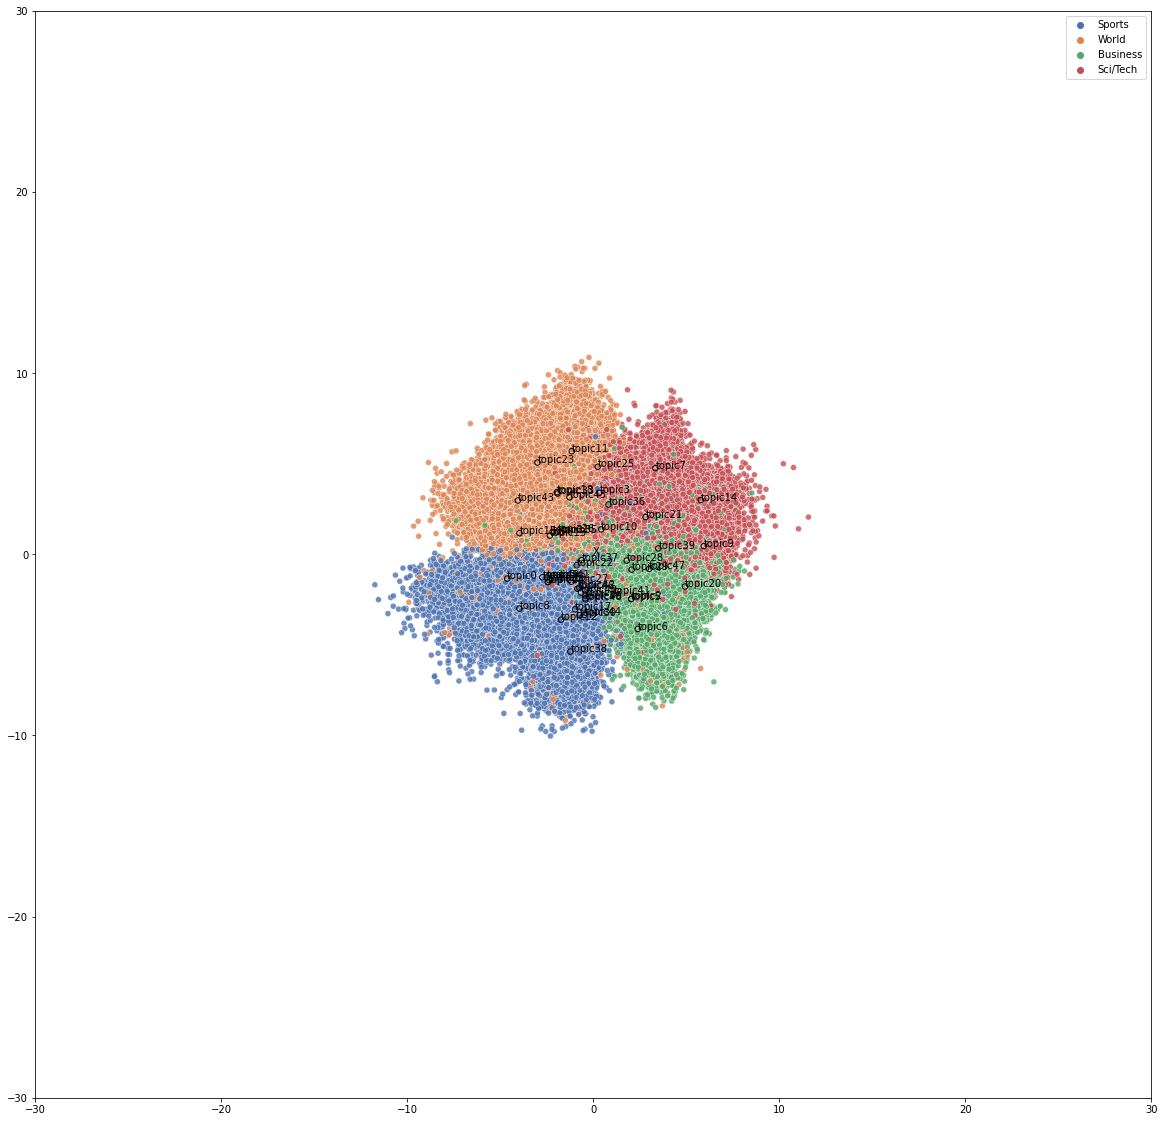

In [ ]:
plot_fig(x_list, labels_list,zphi,lim =30,contour='no')
print("Dropout: ",drop_rate)

In [ ]:
from time import time
fstart = time()
epochs = 1000
num_topic = 10
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

In [ ]:
# Epoch -> 0 , loss -> 15976.621543884277
# recon_loss==> 15778.279319763184 || KLD==> 198.34218072891235
# Epoch -> 10 , loss -> 15219.555908203125
# recon_loss==> 14896.786128997803 || KLD==> 322.7697563171387
# Epoch -> 20 , loss -> 15165.627960205078
# Epoch -> 980 , loss -> 15054.13988494873
# recon_loss==> 14601.796844482422 || KLD==> 452.34307765960693
# Epoch -> 990 , loss -> 15050.796264648438
# recon_loss==> 14600.898105621338 || KLD==> 449.898232460022

# KNN:-  [0.55432, 0.5395, 0.53538, 0.53404, 0.5333] 0.539308

x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)

In [ ]:
plot_fig(x_list, labels_list,zphi,lim =30,contour='no')
print("Dropout: ",drop_rate)

In [ ]:
# NEW KNN
# new_x_list, new_labels_list = not_NaN_docs(x_list,np.asarray(labels_list))
# print('KNN:- ',cal_knn(new_x_list,new_labels_list))

# 1 - Run With GPUDMM NAN DOCS

In [ ]:
NaN_documents = np.array([ 9912, 12034, 12719, 13411, 15470, 16477, 16607, 18790, 27948,
       30085, 30809, 30862, 31183, 31668, 31843, 34077, 34733, 36669,
       38501, 40126, 41529, 42606, 43094, 44042, 45539, 47158, 48817])

def not_NaN_docs(theta,labels):
  # NaN_documents = np.where(np.isnan(theta.sum(-1) ))[0]
  new_theta = []
  new_labels = []
  for th in range(len(theta)):
    if th in NaN_documents: continue
    else:
      new_theta.append(theta[th])
      new_labels.append(labels[th])

  new_theta = np.asarray(new_theta)
  new_labels = np.asarray(new_labels)
  return new_theta,new_labels

In [ ]:
# count_vec,train_label,id_vocab = get_data_label_vocab_for_large_data(data_preprocessed,data_preprocessed_labels,max_features)
# count_vec,train_label,id_vocab = get_data_label_vocab_normal(new_data,new_labels)

count_vec,train_label,id_vocab = get_data_label_vocab_normal(data_preprocessed,data_preprocessed_labels)
all_indices = torch.randperm(count_vec.shape[0]).split(bs)
# embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,old_embeddings)
embedding_tensor_sorted_alp,emb_size = get_doc_word_embeddings(id_vocab,generated_embeddings)

50000 4000
{'energy': 1192, 'united': 3755, 'state': 3400, 'business': 484, 'invest': 1861, 'result': 2997, 'term': 3588, 'profit': 2770, 'level': 2062, 'stage': 3389, 'product': 2764, 'requirement': 2977, 'school': 3113, 'answer': 148, 'search': 3133, 'engine': 1195, 'find': 1379, 'specific': 3354, 'form': 1435, 'travel': 3698, 'trade': 3682, 'left': 2049, 'abusive': 19, 'boyfriend': 421, 'kid': 1971, 'car': 529, 'broke': 452, 'guess': 1592, 'rain': 2850, 'opening': 2470, 'resort': 2985, 'havent': 1636, 'housing': 1733, 'suggestion': 3480, 'running': 3068, 'idea': 1760, 'contact': 767, 'plan': 2642, 'company': 713, 'operation': 2473, 'job': 1930, 'soft': 3311, 'experience': 1273, 'java': 1912, 'extra': 1289, 'time': 3641, 'place': 2640, 'money': 2307, 'programming': 2772, 'testing': 3596, 'relative': 2938, 'computer': 730, 'help': 1659, 'yahoo': 3980, 'website': 3890, 'finance': 1376, 'management': 2176, 'mba': 2219, 'grad': 1555, 'capital': 526, 'firm': 1389, 'ther': 3607, 'course': 

In [ ]:
# torch.var(embedding_tensor_sorted_alp),torch.mean(embedding_tensor_sorted_alp),torch.min(embedding_tensor_sorted_alp),torch.max(embedding_tensor_sorted_alp)

In [ ]:
## variational + kld
from time import time
fstart = time()
epochs = 1000
num_topic = 10
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

0.001 0.99 0.999


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



Epoch -> 0 , loss -> 16504.618156433105
recon_loss==> 15859.82430267334 || KLD==> 644.7938385009766
Epoch -> 10 , loss -> 14826.849250793457
recon_loss==> 14718.148212432861 || KLD==> 108.70102989673615
Epoch -> 20 , loss -> 14725.262092590332
recon_loss==> 14634.141746520996 || KLD==> 91.12033161520958
Epoch -> 30 , loss -> 14671.211902618408
recon_loss==> 14592.857612609863 || KLD==> 78.3542021214962
Epoch -> 40 , loss -> 14654.458721160889
recon_loss==> 14580.557334899902 || KLD==> 73.90135452151299
Epoch -> 50 , loss -> 14641.538536071777
recon_loss==> 14570.701244354248 || KLD==> 70.83728754520416
Epoch -> 60 , loss -> 14633.100090026855
recon_loss==> 14563.831981658936 || KLD==> 69.26812314987183
Epoch -> 70 , loss -> 14623.359985351562
recon_loss==> 14556.684371948242 || KLD==> 66.67559084296227
Epoch -> 80 , loss -> 14618.651767730713
recon_loss==> 14552.79610824585 || KLD==> 65.85567706823349
Epoch -> 90 , loss -> 14607.96908569336
recon_loss==> 14543.521709442139 || KLD==> 64

In [ ]:
x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



------------------------------
0: woman man black men white doe movie wear thing heard
1: computer yahoo file window internet help mail program email address
2: money pay company job work find year doe business credit
3: help answer school question good doe find word college year
4: doe number find water earth point speed explain energy cell
5: song site music find movie website free doe good video
6: day help doe weight doctor pain time week work long
7: friend guy love girl time year don thing help feel
8: team win game player cup football fan year best play
9: people god country american war christian don bush question jesus
------------------------------
KNN:-  [0.5825, 0.56588, 0.5621, 0.55992, 0.55718] 0.565516


In [ ]:
from time import time
fstart = time()
epochs = 1000
num_topic = 10
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

In [ ]:
x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)

------------------------------
0: software system technology service company wireless computer corp mobile microsoft
1: space scientist nasa people researcher year water storm study spacecraft
2: reuters stock price oil investor percent york ticker sale quarter
3: game night season sunday point victory series win red league
4: president minister election government bush state prime country leader iran
5: company billion executive corp group federal thursday pay chief bid
6: quot year coach team football player time club star fan
7: cup champion final olympic match round win second athens saturday
8: internet online microsoft music search computer google user web font
9: killed iraq iraqi baghdad militant people police attack palestinian soldier
------------------------------
KNN:-  [0.8574179992996381, 0.85394120295486, 0.8524320899131218, 0.8517817539061848, 0.8514815988260601] 0.853410928979973


Dropout:  0.0


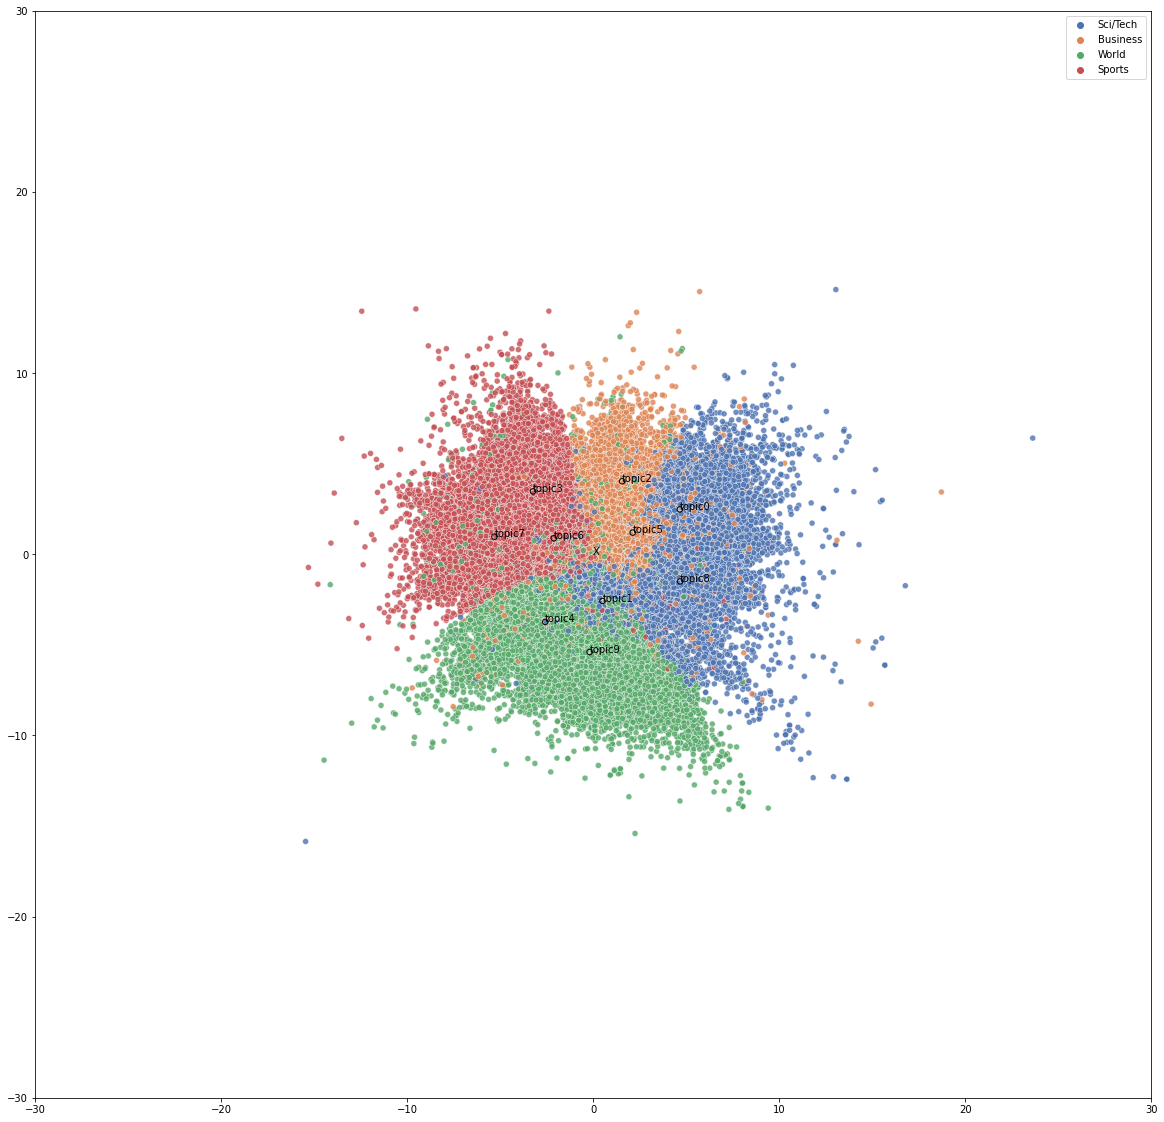

In [ ]:
plot_fig(x_list, labels_list,zphi,lim =30,contour='no')
print("Dropout: ",drop_rate)

In [ ]:
from time import time
fstart = time()
epochs = 1000
num_topic = 10
num_input = count_vec.shape[1]
model = train(count_vec,train_label,num_input,num_topic,embedding_tensor_sorted_alp,all_indices,epochs)
stop = time()

0.001 0.99 0.999
Epoch -> 0 , loss -> 15813.592166900635
recon_loss==> 15813.592166900635 || KLD==> 274.9004669189453
Epoch -> 10 , loss -> 14610.379402160645
recon_loss==> 14610.379402160645 || KLD==> 1418.5565128326416
Epoch -> 20 , loss -> 14506.034397125244
recon_loss==> 14506.034397125244 || KLD==> 2219.1259479522705
Epoch -> 30 , loss -> 14494.384037017822
recon_loss==> 14494.384037017822 || KLD==> 2965.26780128479
Epoch -> 40 , loss -> 14484.725498199463
recon_loss==> 14484.725498199463 || KLD==> 3772.337142944336
Epoch -> 50 , loss -> 14478.291389465332
recon_loss==> 14478.291389465332 || KLD==> 4597.562089920044
Epoch -> 60 , loss -> 14487.329593658447
recon_loss==> 14487.329593658447 || KLD==> 5539.173700332642
Epoch -> 70 , loss -> 14459.691204071045
recon_loss==> 14459.691204071045 || KLD==> 6515.603588104248
Epoch -> 80 , loss -> 14449.058555603027
recon_loss==> 14449.058555603027 || KLD==> 7307.5029373168945
Epoch -> 90 , loss -> 14461.623600006104
recon_loss==> 14461.623

In [ ]:
# Epoch -> 0 , loss -> 15976.621543884277
# recon_loss==> 15778.279319763184 || KLD==> 198.34218072891235
# Epoch -> 10 , loss -> 15219.555908203125
# recon_loss==> 14896.786128997803 || KLD==> 322.7697563171387
# Epoch -> 20 , loss -> 15165.627960205078
# Epoch -> 980 , loss -> 15054.13988494873
# recon_loss==> 14601.796844482422 || KLD==> 452.34307765960693
# Epoch -> 990 , loss -> 15050.796264648438
# recon_loss==> 14600.898105621338 || KLD==> 449.898232460022

# KNN:-  [0.55432, 0.5395, 0.53538, 0.53404, 0.5333] 0.539308

x_list,labels_list,zphi,doc_ids,beta = test(model,all_indices,count_vec,train_label,id_vocab)

------------------------------
0: people country american war bush state america president iraq government
1: song god christian jesus religion people bible doe life muslim
2: team win game cup player football fan play sport best
3: guy love friend girl time thing feel don woman year
4: answer find doe question site help website word yahoo movie
5: doe number water find help point explain speed earth time
6: doe weight help day eat long doctor pain body week
7: school good help job work money company find college year
8: computer file window internet yahoo help download program software work
9: year time doe child day live house work life people
------------------------------
KNN:-  [0.56988, 0.55226, 0.54694, 0.5452, 0.54236] 0.551328


Dropout:  0.0


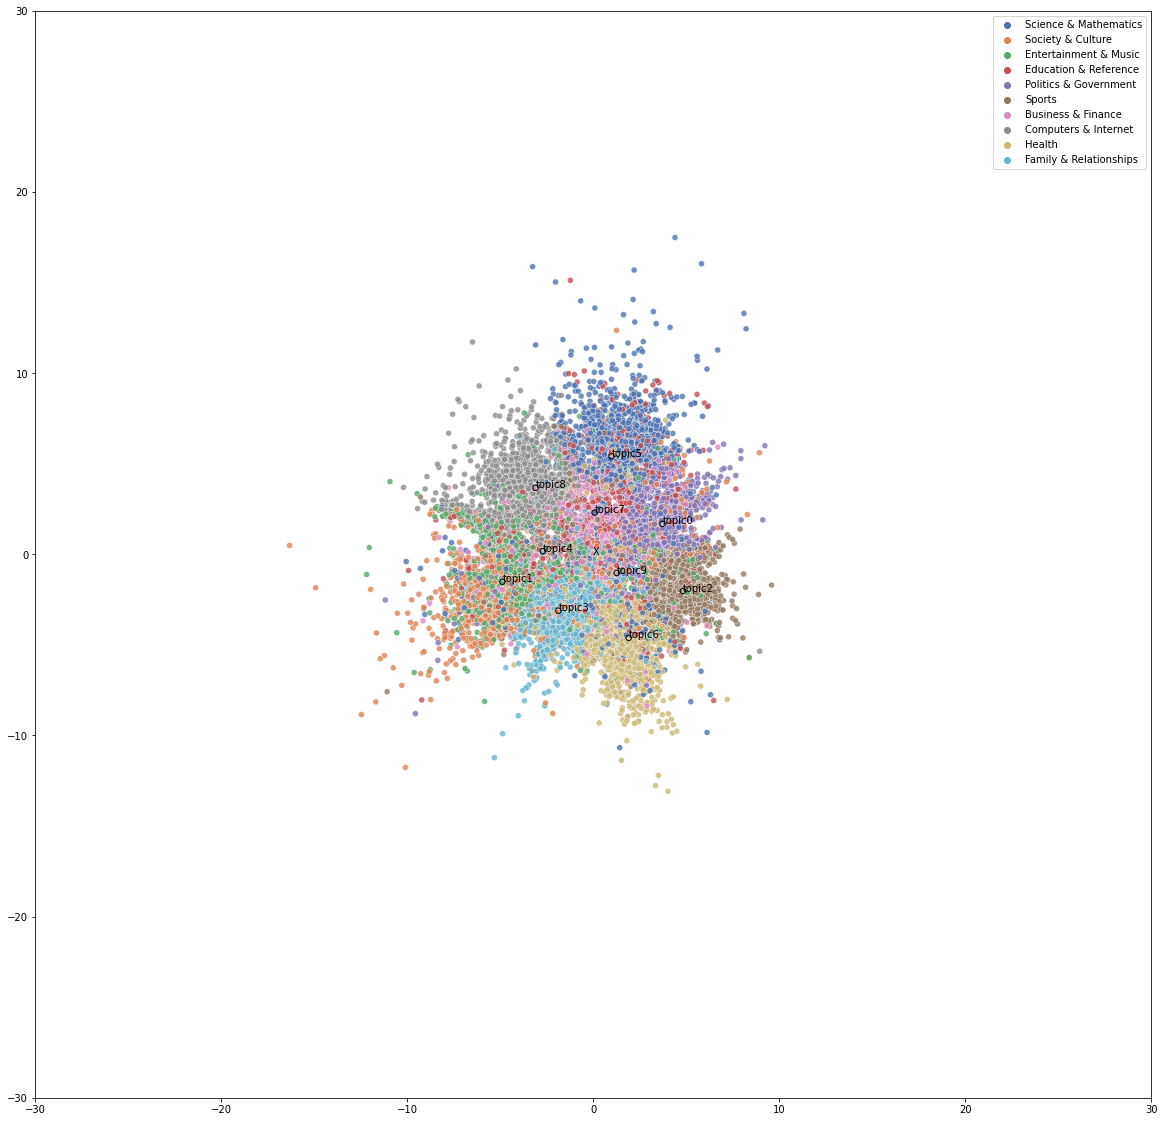

In [ ]:
plot_fig(x_list, labels_list,zphi,lim =30,contour='no')
print("Dropout: ",drop_rate)

In [ ]:
# NEW KNN
# new_x_list, new_labels_list = not_NaN_docs(x_list,np.asarray(labels_list))
# print('KNN:- ',cal_knn(new_x_list,new_labels_list))

# Github


In [ ]:
!zip -r updated_WTM_files_w_code.zip *.*

  adding: all_words_pairs_WTM_for_NPMI.txt (deflated 77%)
  adding: all_WTM_files_w_code.zip (stored 0%)
  adding: data.py (deflated 69%)
  adding: main.py (deflated 68%)
  adding: README.md (deflated 51%)
  adding: run_py_script.sh (deflated 15%)
  adding: run_script.py (deflated 56%)
  adding: train_evaluation.py (deflated 81%)
  adding: utils.py (deflated 63%)
  adding: wtm.py (deflated 73%)


In [ ]:
!git push

Username for 'https://github.com': ^C


In [ ]:
# !git clone https://github.com/sanujsriv/WTM.git

Cloning into 'WTM'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# !wget https://www.dropbox.com/s/4sqr32grbhnwx65/bbc_2000_%20%281%29.zip
!unzip bbc_2000.zip

In [ ]:
!python main.py --dataset bbc --run 11 --have_KLD 'True' --skipgram_embeddings 0

In [ ]:
!pwd

/home/grad16/sakumar/CIKM_Experiments_2021/WTM


In [ ]:
!zip -r VLDB_WTM_Datasets.zip /home/grad16/sakumar/CIKM_Experiments_2021/WTM/content/

In [ ]:
import pickle,pickle5
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_obj_pkl5(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle5.load(f)

In [ ]:
import os
home_dir='/home/grad16/sakumar/CIKM_Experiments_2021/WTM'
data_dir = '/content/data_bbc/short/'

dir= '/home/grad16/sakumar/colab/preprocessing/newEmbeddings/data_bbc/short/'
os.chdir(dir)
gen_emb  = load_obj_pkl5("generated_embeddings_bbc_short")
os.chdir(home_dir)

In [ ]:
from gensim import models
# if not os.path.isfile("/home/grad16/sakumar/miniconda3/bin/GoogleNews-vectors-negative300.bin"):
  # !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
  # !gunzip GoogleNews-vectors-negative300.bin.gz
word2vec_model = models.KeyedVectors.load_word2vec_format('/home/grad16/sakumar/miniconda3/bin/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
embeddings = {}
list_of_words = list(gen_emb.keys())
for l in list_of_words:
  embeddings[l] = word2vec_model[l]

In [ ]:
'yukos' in list_of_words

True

In [ ]:
# !wget -N -c https://www.dropbox.com/s/yt01lglmwyfwpot/VLDB_WTM_Datasets.zip
!unzip -o VLDB_WTM_Datasets.zip

Archive:  VLDB_WTM_Datasets.zip
   creating: content/
   creating: content/data_bbc/
   creating: content/data_bbc/short/
  inflating: content/data_bbc/short/vocab_bbc_short.pkl  
  inflating: content/data_bbc/short/bbc_short.txt  
  inflating: content/data_bbc/short/data_preprocessed_labels_bbc_short.pkl  
  inflating: content/data_bbc/short/generated_embeddings_bbc_short.pkl  
   creating: content/data_bbc/short/.ipynb_checkpoints/
  inflating: content/data_bbc/short/embeddings_bbc_short.pkl  
  inflating: content/data_bbc/short/data_preprocessed_bbc_short.pkl  
   creating: content/data_searchsnippet/
   creating: content/data_searchsnippet/short/
  inflating: content/data_searchsnippet/short/searchsnippet_short.txt  
  inflating: content/data_searchsnippet/short/data_preprocessed_searchsnippet_short.pkl  
  inflating: content/data_searchsnippet/short/embeddings_searchsnippet_short.pkl  
  inflating: content/data_searchsnippet/short/data_preprocessed_labels_searchsnippet_short.pkl  